In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(6)

# 1. Examining the data

We will be using k-nearest neighbours to classify and cluster a dataset of faces. We're using the Olivetti dataset, which contains 400 images of 40 people (10 images per person). Each image is 64x64 and in black and white.

Is KNN a good approach to classifying the data?

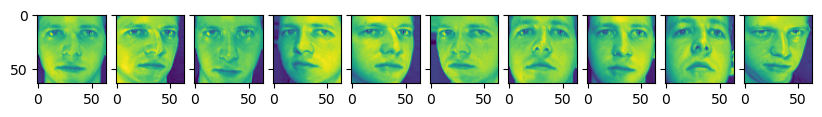

In [13]:
from sklearn import datasets
from mpl_toolkits.axes_grid1 import ImageGrid

x,y = datasets.fetch_olivetti_faces(return_X_y=True)
def plot_images(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((64,64)))
    plt.show()
plot_images(x[:10])

# 2. Designing the model

Write the steps (or pseudocode) for how to find the k-nearest neighbours.

# Testing the code

Find the 10 nearest neighbours of the first face in the dataset.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

knn = KNeighborsClassifier(10)
knn.fit(X_train, y_train)

y_predicted = knn.predict(X_test)
accuracy_score(y_test, y_predicted)

C:\Users\linag\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\linag\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\linag\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\linag\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\linag\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

0.6

# 3. Hyperparameter tuning

Questions:

*   What is the hyperparameter?
*   How would we determine the best value for the hyperparameter?
*   What range of values should we consider?
*   Pseudocode





In [18]:
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

def shuffle_and_get_val(x,y,rs,val_size):
    x_shuffle,y_shuffle = shuffle(x, y, random_state = rs)
    x_val,y_val = x_shuffle[:val_size],y_shuffle[:val_size]
    x_train,y_train = x_shuffle[val_size:],y_shuffle[val_size:]

    return x_train,y_train,x_val,y_val

def find_best_k(r,x_train,y_train,x_test,y_test):
    '''
    Returns the k that yields the best accuracy for KNNS classification, and its
    accuracy. If two k's yield the same accuracy, returns the larger one to reduce overfitting.
    r = range of k's to check accuracy for
    '''
    test_size = np.shape(y_test)[0]
    best_k = 0
    best_acc = 0

    for j in range(1,r+1):
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(x_train, y_train)
        y = knn.predict(x_test)

        acc = np.sum(y == y_test)/test_size

        if acc >= best_acc:
            best_k = j
            best_acc = acc

    return best_k, best_acc

In [19]:
# shuffle dimensionality-reduced data and get training and test set
x_train,y_train,x_val,y_val = shuffle_and_get_val(x,y,2,80)

# optimize for K from 1-10
best_k, best_acc = find_best_k(10,x_train,y_train,x_val,y_val)

print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

best validation accuracy is 96.25 percent, using k=1


# Principal Component Analysis

Each face image has 4096 parameters (pixels). But most of the variance in the data can be explained with far fewer components.

We want a mapping between our data space (4096 dimensions) to a lower dimensional space, without losing too much information. I.e. we want to **faithfully** represent the data with fewer dimensions.

For simplicity, we'll assume this mapping is linear, so we can describe it with a matrix $Q$. We assume $Q$ is orthonormal, with inverse $Q^T$.

We want to minimize the **reconstruction error** given by $\min_Q = \sum_n||x^{(n)} - x^{(n)}QQ^T||_2^2$.

Since $Q$ is orthogonal, we can think of it as a change of coordinates. We want to change the coordinate such that the first $n$ new coordinates best explain the data, for any $n$.

So we want coordinates that emphasize the variance in the data. The first new coordinate should have the maximum variance, the second coordinate should have the second highest variance, etc.

If $X$ is the matrix containing our data, let $\sum = \frac{1}{N}X^TX$ be the covariance matrix.

It turns out that this $Q$ corresponds to the matrix of eigenvectors of $\sum$.

Visualizing the eigenfaces:

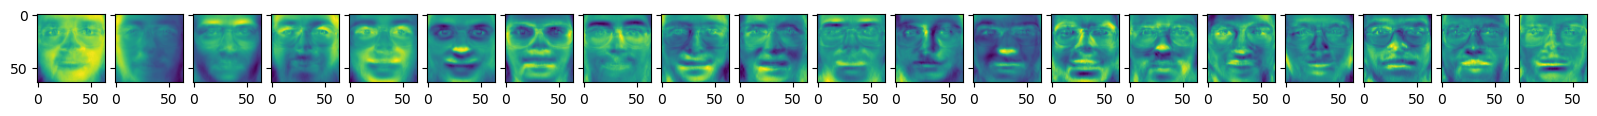

In [22]:
x_norm = x - np.mean(x,axis=0) # normalizing the data

u,s,vt = np.linalg.svd(x_norm, full_matrices=False) # the Singular Value Decomposition (SVD) is used to do the PCA
plot_images(vt[:20])

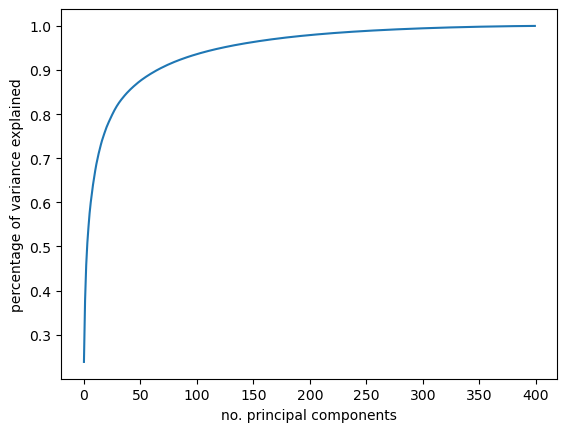

95% of the variance is explained using 123 principal components


In [23]:
variances = np.var(x_norm @ vt.T, axis=0)
var_explained = np.cumsum(variances/np.sum(variances))
L = np.where(var_explained >= 0.95)[0][0] + 1

plt.plot(var_explained)
plt.xlabel("no. principal components")
plt.ylabel("percentage of variance explained")
plt.show()
print(f'95% of the variance is explained using {L} principal components')

We repeat KNN, using the faces in the embedding space.

In [25]:
# convert training, test data to 100 principal components
v = np.transpose(vt)[:,:125]
x_dr = np.matmul(x_norm,v)

# shuffle dimensionality-reduced data and get training and test set
x_train_dr,y_train_dr,x_val_dr,y_val_dr = shuffle_and_get_val(x_dr,y,2,80)

# optimize for K from 1-10
best_k, best_acc = find_best_k(10,x_train_dr,y_train_dr,x_val_dr,y_val_dr)

print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

best validation accuracy is 95.0 percent, using k=1


Finally, we divide the faces into k=40 clusters, and plot the images for 10 clusters.

C:\Users\linag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


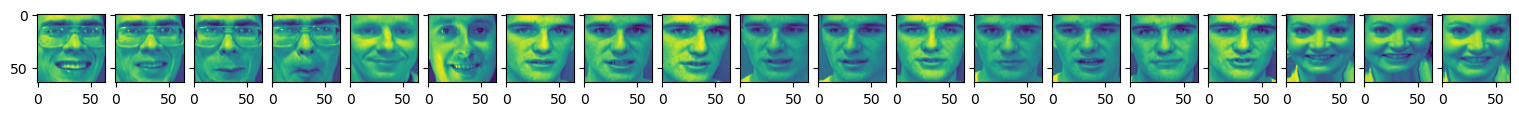

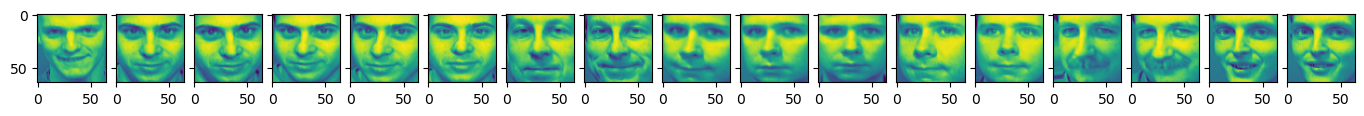

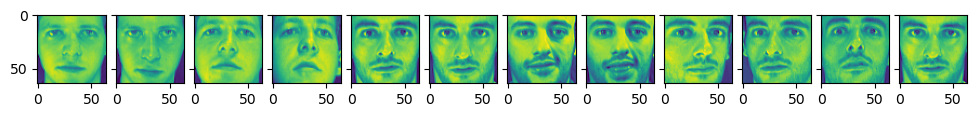

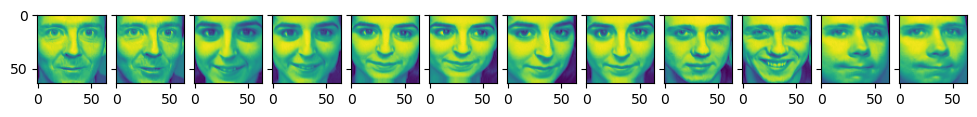

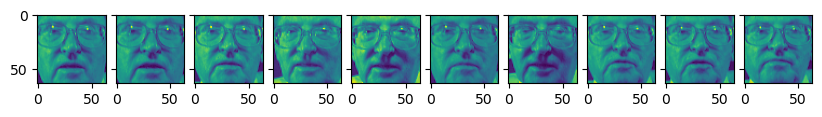

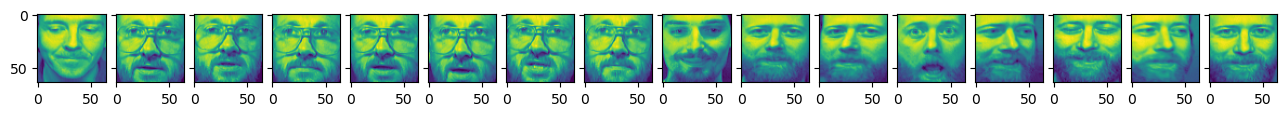

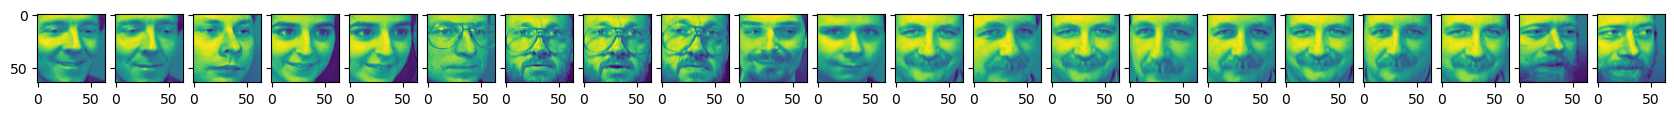

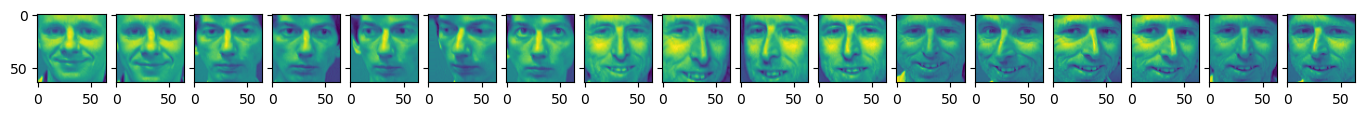

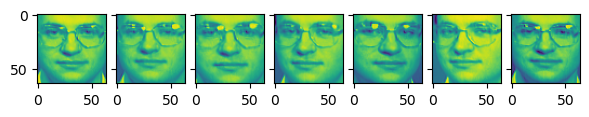

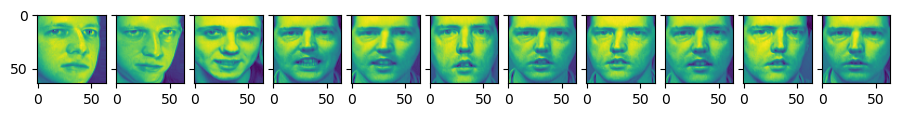

In [27]:
from sklearn import cluster

cl = cluster.KMeans(n_clusters=40).fit(x)
indices = np.arange(400)

for i in range(10):
  c = indices[cl.labels_[indices] == i]
  plot_images(x[c])